In [1]:
import freegs
import numpy as np
from freegs.machine import MirroredCoil, Solenoid, Wall
from freegs import optimise as opt

In [2]:
PR1 = 0.50738376
PZ1 = 0.39384023
PR2 = 0.62576723
PZ2 = 0.1996288

In [3]:
poloidal_coils = [
    ('PF1', MirroredCoil(PR1, PZ1)),
    ('PF2', MirroredCoil(PR2, PZ2))
]

In [4]:
solenoid_height = 0.94
inner_radius = 51e-3
outer_radius = 60e-3
solenoid_turns = 104
central_solenoid = [("SOL", Solenoid((inner_radius + outer_radius) / 2, -solenoid_height / 2, solenoid_height / 2,
                                     solenoid_turns, control=False))]

In [5]:
R0 = 0.28     # Middle of the circle
rwall = 0.12 # Radius of the circular wall

npoints = 200 # Number of points on the wall

# Poloidal angles
thetas = np.linspace(0, 2*np.pi, npoints, endpoint=False)

# Points on the wall
Rwalls = R0 + rwall * np.cos(thetas)
Zwalls = rwall * np.sin(thetas)

walls = Wall (
    Rwalls,
    Zwalls
)

In [6]:
tokamak = freegs.machine.Machine(
    central_solenoid + poloidal_coils,
    walls
)

In [7]:
tokamak['PF1']['U'].area = tokamak['PF1']['L'].area = tokamak['PF2']['U'].area = tokamak['PF2']['L'].area = 0.000213825*4

In [8]:
eq = freegs.Equilibrium(tokamak=tokamak,
                        Rmin=0.01, Rmax=0.6,    # Radial domain
                        Zmin=-0.5, Zmax=0.5,   # Height range
                        nx=65, ny=65          # Number of grid points
                        )

In [9]:
plasma_major_radius = 0.28
toroidal_magnetic_field_strength_at_plasma_centre = 0.875
vacuum_toroidal_magnetic_field = plasma_major_radius * toroidal_magnetic_field_strength_at_plasma_centre

In [10]:
profiles = freegs.jtor.ConstrainBetapIp(eq,
                                        0.05, # Plasma poloidal beta
                                        3e3, # Plasma current [Amps]
                                        vacuum_toroidal_magnetic_field) # Vacuum f=R*Bt

In [11]:
xpoints = [(0.3, -0.24), (0.3, 0.24)]  # (R,Z) locations of X-points

isoflux = [(0.3, -0.24, 0.3, 0.24)] # (R1,Z1, R2,Z2) pairs
constrain = freegs.control.constrain(isoflux=isoflux, xpoints=xpoints)

In [12]:
freegs.solve(eq,
             profiles,
             constrain,
             show=False,
             check_limited=True,
             wait_for_limited=True,
             limit_it=0
             )

In [13]:
eq.tokamak.printCurrents()
d = eq.tokamak.getCurrents()
total_current = 0
for _, v in d.items():
    total_current += abs(v)
print(total_current)

SOL : Solenoid(Rs=0.055499999999999994, Zsmin=-0.47, Zsmax=0.47, current=0.0, Ns=104, control=False)
PF1 : Circuit([("U", Coil(R=0.50738376, Z=0.39384023, current=2590.3, turns=1, control=True), 1.0), ("L", Coil(R=0.50738376, Z=-0.39384023, current=2590.3, turns=1, control=True), 1.0)], current=2590.2580912563835, control=True)
PF2 : Circuit([("U", Coil(R=0.62576723, Z=0.1996288, current=-2801.7, turns=1, control=True), 1.0), ("L", Coil(R=0.62576723, Z=-0.1996288, current=-2801.7, turns=1, control=True), 1.0)], current=-2801.6550480969013, control=True)
5391.913139353284


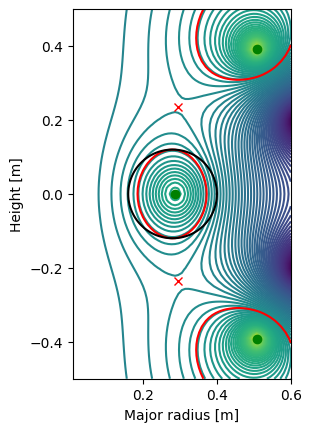

<Axes: xlabel='Major radius [m]', ylabel='Height [m]'>

In [14]:
axis = eq.plot(show=False)
eq.tokamak.plot(axis=axis, show=True)
constrain.plot(axis=axis, show=False)

In [15]:
eq.intersectsWall()

False

/home/roy/DataspellProjects/AtomCraft_Plasma_Modelling/pf_coil_optimisation/freegs/critical.py:424: UserWarning: Theta grid too close to X-point, shifting by half-step
  warn("Theta grid too close to X-point, shifting by half-step")


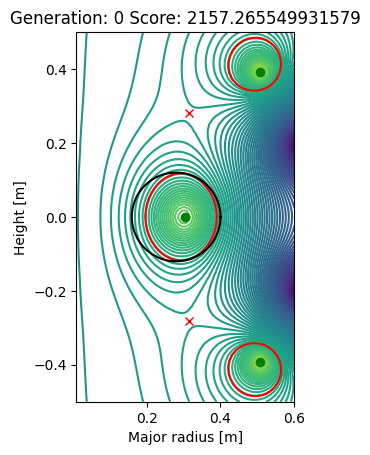

/home/roy/DataspellProjects/AtomCraft_Plasma_Modelling/pf_coil_optimisation/freegs/critical.py:424: UserWarning: Theta grid too close to X-point, shifting by half-step
  warn("Theta grid too close to X-point, shifting by half-step")
/home/roy/DataspellProjects/AtomCraft_Plasma_Modelling/pf_coil_optimisation/freegs/critical.py:424: UserWarning: Theta grid too close to X-point, shifting by half-step
  warn("Theta grid too close to X-point, shifting by half-step")
/home/roy/DataspellProjects/AtomCraft_Plasma_Modelling/pf_coil_optimisation/freegs/critical.py:424: UserWarning: Theta grid too close to X-point, shifting by half-step
  warn("Theta grid too close to X-point, shifting by half-step")
/home/roy/DataspellProjects/AtomCraft_Plasma_Modelling/pf_coil_optimisation/freegs/critical.py:424: UserWarning: Theta grid too close to X-point, shifting by half-step
  warn("Theta grid too close to X-point, shifting by half-step")
/home/roy/DataspellProjects/AtomCraft_Plasma_Modelling/pf_coil_optim

In [31]:
best_eq = opt.optimise(eq,  # Starting equilibrium 
                       # List of controls
                       [
                           opt.CoilRadius('PF1'),
                           opt.CoilRadius('PF2'),
                           opt.CoilHeight('PF1'),
                           opt.CoilHeight('PF2')
                       ],
                       # The function to minimise
                       opt.weighted_sum(opt.max_abs_coil_current, opt.no_wall_intersection),
                       N=10,  # Number of solutions in each generation
                       maxgen=30 ,  # How many generations
                       monitor=opt.PlotMonitor())  # Plot the best in each generation

In [36]:
# Original Dimensions (R,Z) (0.51, 0.39) (0.63, 0.2)
print(
    f"R: {best_eq.tokamak['PF1']['U'].R :.2f}",
    f"Z: {best_eq.tokamak['PF1']['U'].Z :.2f}"
)

R: 0.39 Z: 0.34


In [37]:
print(
    f"R: {best_eq.tokamak['PF2']['U'].R :.2f}",
    f"Z: {best_eq.tokamak['PF2']['U'].Z :.2f}"
)

R: 0.62 Z: 0.20


In [38]:
best_eq.tokamak.printCurrents()

SOL : Solenoid(Rs=0.055499999999999994, Zsmin=-0.47, Zsmax=0.47, current=0.0, Ns=104, control=False)
PF1 : Circuit([("U", Coil(R=0.39436926841412817, Z=0.3375674207323604, current=749.5, turns=1, control=True), 1.0), ("L", Coil(R=0.39436926841412817, Z=0.3375674207323604, current=749.5, turns=1, control=True), 1.0)], current=749.5308338059705, control=True)
PF2 : Circuit([("U", Coil(R=0.6188221506437056, Z=0.1959630365759053, current=-1707.1, turns=1, control=True), 1.0), ("L", Coil(R=0.6188221506437056, Z=0.1959630365759053, current=-1707.1, turns=1, control=True), 1.0)], current=-1707.1280294264504, control=True)


In [40]:
best_eq.tokamak.printCurrents()
d = best_eq.tokamak.getCurrents()
total_current = 0
for _, v in d.items():
    total_current += abs(v)
print(total_current)

SOL : Solenoid(Rs=0.055499999999999994, Zsmin=-0.47, Zsmax=0.47, current=0.0, Ns=104, control=False)
PF1 : Circuit([("U", Coil(R=0.39436926841412817, Z=0.3375674207323604, current=749.5, turns=1, control=True), 1.0), ("L", Coil(R=0.39436926841412817, Z=0.3375674207323604, current=749.5, turns=1, control=True), 1.0)], current=749.5308338059705, control=True)
PF2 : Circuit([("U", Coil(R=0.6188221506437056, Z=0.1959630365759053, current=-1707.1, turns=1, control=True), 1.0), ("L", Coil(R=0.6188221506437056, Z=0.1959630365759053, current=-1707.1, turns=1, control=True), 1.0)], current=-1707.1280294264504, control=True)
2456.658863232421


In [41]:
print(
    best_eq.tokamak['PF1']['U'].R,
    best_eq.tokamak['PF1']['U'].Z,
    best_eq.tokamak['PF2']['U'].R,
    best_eq.tokamak['PF2']['U'].Z
)

0.39436926841412817 0.3375674207323604 0.6188221506437056 0.1959630365759053
